<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Final%20Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
# !git pull origin master
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

Cloning into 'TSAI-EVA40-Assignments'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (331/331), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 1167 (delta 228), reused 79 (delta 45), pack-reused 836
Receiving objects: 100% (1167/1167), 25.71 MiB | 29.22 MiB/s, done.
Resolving deltas: 100% (693/693), done.


In [3]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy
import pandas as pd

In [4]:
trainloader,testloader = cifar_data_loader(BatchSize=250)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1


Learning rate search finished. See the graph with {finder_name}.plot()


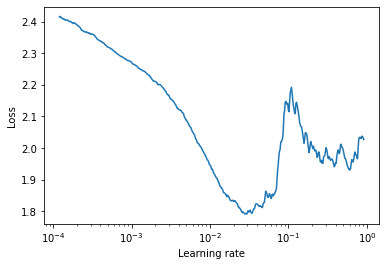

In [6]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()


In [7]:
lr_ = pd.DataFrame(lr_finder.history)
lr_max = lr_.loc[lr_['loss']==lr_['loss'].min(),'lr'].values[0]
lr_max

0.02944000475100034

In [8]:
net = ResNet18().to(device)
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr_max, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

for epoch in range(50):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.5023586750030518 Batch_id=199 Accuracy=40.33: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -2.9414, Accuracy: 5623/10000 (56.23%)

EPOCH: 1


Loss=1.1984846591949463 Batch_id=199 Accuracy=57.10: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.0904, Accuracy: 6307/10000 (63.07%)

EPOCH: 2


Loss=0.9690803289413452 Batch_id=199 Accuracy=65.71: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.7340, Accuracy: 7103/10000 (71.03%)

EPOCH: 3


Loss=0.8684747815132141 Batch_id=199 Accuracy=70.69: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.7242, Accuracy: 7540/10000 (75.40%)

EPOCH: 4


Loss=0.8570532202720642 Batch_id=199 Accuracy=74.04: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.5825, Accuracy: 7663/10000 (76.63%)

EPOCH: 5


Loss=0.7076561450958252 Batch_id=199 Accuracy=76.20: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.0463, Accuracy: 7962/10000 (79.62%)

EPOCH: 6


Loss=0.5901301503181458 Batch_id=199 Accuracy=78.52: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.3057, Accuracy: 8123/10000 (81.23%)

EPOCH: 7


Loss=0.5777419805526733 Batch_id=199 Accuracy=80.16: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.4745, Accuracy: 8252/10000 (82.52%)

EPOCH: 8


Loss=0.5600520372390747 Batch_id=199 Accuracy=81.03: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.8762, Accuracy: 8217/10000 (82.17%)

EPOCH: 9


Loss=0.5617693662643433 Batch_id=199 Accuracy=82.20: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.6666, Accuracy: 8227/10000 (82.27%)

EPOCH: 10


Loss=0.5693899393081665 Batch_id=199 Accuracy=83.06: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.2536, Accuracy: 8450/10000 (84.50%)

EPOCH: 11


Loss=0.4762037396430969 Batch_id=199 Accuracy=83.92: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3757, Accuracy: 8437/10000 (84.37%)

EPOCH: 12


Loss=0.5221388936042786 Batch_id=199 Accuracy=84.78: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.7316, Accuracy: 8459/10000 (84.59%)

EPOCH: 13


Loss=0.4884316623210907 Batch_id=199 Accuracy=85.04: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.9684, Accuracy: 8533/10000 (85.33%)

EPOCH: 14


Loss=0.4661901891231537 Batch_id=199 Accuracy=85.85: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2160, Accuracy: 8619/10000 (86.19%)

EPOCH: 15


Loss=0.4015826880931854 Batch_id=199 Accuracy=86.30: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5184, Accuracy: 8701/10000 (87.01%)

EPOCH: 16


Loss=0.340219110250473 Batch_id=199 Accuracy=86.75: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5125, Accuracy: 8711/10000 (87.11%)

EPOCH: 17


Loss=0.4511488378047943 Batch_id=199 Accuracy=87.63: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1389, Accuracy: 8754/10000 (87.54%)

EPOCH: 18


Loss=0.41012266278266907 Batch_id=199 Accuracy=87.83: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2069, Accuracy: 8790/10000 (87.90%)

EPOCH: 19


Loss=0.34519341588020325 Batch_id=199 Accuracy=88.07: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4820, Accuracy: 8695/10000 (86.95%)

EPOCH: 20


Loss=0.2679353952407837 Batch_id=199 Accuracy=88.80: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5327, Accuracy: 8737/10000 (87.37%)

EPOCH: 21


Loss=0.27797624468803406 Batch_id=199 Accuracy=89.11: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.6539, Accuracy: 8828/10000 (88.28%)

EPOCH: 22


Loss=0.3031750023365021 Batch_id=199 Accuracy=89.39: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.7797, Accuracy: 8871/10000 (88.71%)

EPOCH: 23


Loss=0.3113069236278534 Batch_id=199 Accuracy=89.86: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.7891, Accuracy: 8883/10000 (88.83%)

EPOCH: 24


Loss=0.31035006046295166 Batch_id=199 Accuracy=89.85: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1961, Accuracy: 8859/10000 (88.59%)

EPOCH: 25


Loss=0.2834934592247009 Batch_id=199 Accuracy=90.15: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.8747, Accuracy: 8839/10000 (88.39%)

EPOCH: 26


Loss=0.23759259283542633 Batch_id=199 Accuracy=90.40: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9947, Accuracy: 8837/10000 (88.37%)

EPOCH: 27


Loss=0.34335556626319885 Batch_id=199 Accuracy=90.53: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.8708, Accuracy: 8852/10000 (88.52%)

EPOCH: 28


Loss=0.22393743693828583 Batch_id=199 Accuracy=91.04: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2615, Accuracy: 8921/10000 (89.21%)

EPOCH: 29


Loss=0.3448079526424408 Batch_id=199 Accuracy=90.90: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9965, Accuracy: 8925/10000 (89.25%)

EPOCH: 30


Loss=0.3565389811992645 Batch_id=199 Accuracy=91.46: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.3034, Accuracy: 8940/10000 (89.40%)

EPOCH: 31


Loss=0.2568778097629547 Batch_id=199 Accuracy=91.34: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.3409, Accuracy: 8839/10000 (88.39%)

EPOCH: 32


Loss=0.21545802056789398 Batch_id=199 Accuracy=91.81: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.7923, Accuracy: 8886/10000 (88.86%)

EPOCH: 33


Loss=0.2498711794614792 Batch_id=199 Accuracy=92.08: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.0713, Accuracy: 8909/10000 (89.09%)

EPOCH: 34


Loss=0.20297367870807648 Batch_id=199 Accuracy=92.10: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.7979, Accuracy: 8998/10000 (89.98%)

EPOCH: 35


Loss=0.21859392523765564 Batch_id=199 Accuracy=92.29: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2921, Accuracy: 8948/10000 (89.48%)

EPOCH: 36


Loss=0.22951172292232513 Batch_id=199 Accuracy=92.39: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9907, Accuracy: 8930/10000 (89.30%)

EPOCH: 37


Loss=0.19575197994709015 Batch_id=199 Accuracy=92.75: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2771, Accuracy: 9009/10000 (90.09%)

Epoch    38: reducing learning rate of group 0 to 2.9440e-03.
EPOCH: 38


Loss=0.08126998692750931 Batch_id=199 Accuracy=95.28: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6962, Accuracy: 9221/10000 (92.21%)

EPOCH: 39


Loss=0.09425756335258484 Batch_id=199 Accuracy=96.57: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.8154, Accuracy: 9238/10000 (92.38%)

EPOCH: 40


Loss=0.09631987661123276 Batch_id=199 Accuracy=96.76: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.9585, Accuracy: 9260/10000 (92.60%)

EPOCH: 41


Loss=0.0884370356798172 Batch_id=199 Accuracy=96.92: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.9491, Accuracy: 9245/10000 (92.45%)

EPOCH: 42


Loss=0.06117399036884308 Batch_id=199 Accuracy=97.23: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0133, Accuracy: 9280/10000 (92.80%)

EPOCH: 43


Loss=0.048394057899713516 Batch_id=199 Accuracy=97.39: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0796, Accuracy: 9273/10000 (92.73%)

EPOCH: 44


Loss=0.0843004360795021 Batch_id=199 Accuracy=97.53: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0610, Accuracy: 9273/10000 (92.73%)

EPOCH: 45


Loss=0.10748215764760971 Batch_id=199 Accuracy=97.69: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0227, Accuracy: 9289/10000 (92.89%)

EPOCH: 46


Loss=0.0918181762099266 Batch_id=199 Accuracy=97.73: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.1341, Accuracy: 9286/10000 (92.86%)

EPOCH: 47


Loss=0.04730875417590141 Batch_id=199 Accuracy=97.84: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.0902, Accuracy: 9274/10000 (92.74%)

EPOCH: 48


Loss=0.09467413276433945 Batch_id=199 Accuracy=97.94: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -11.1618, Accuracy: 9262/10000 (92.62%)

EPOCH: 49


Loss=0.039417922496795654 Batch_id=199 Accuracy=97.97: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]



Test set: Average loss: -11.1720, Accuracy: 9292/10000 (92.92%)

Finished Training


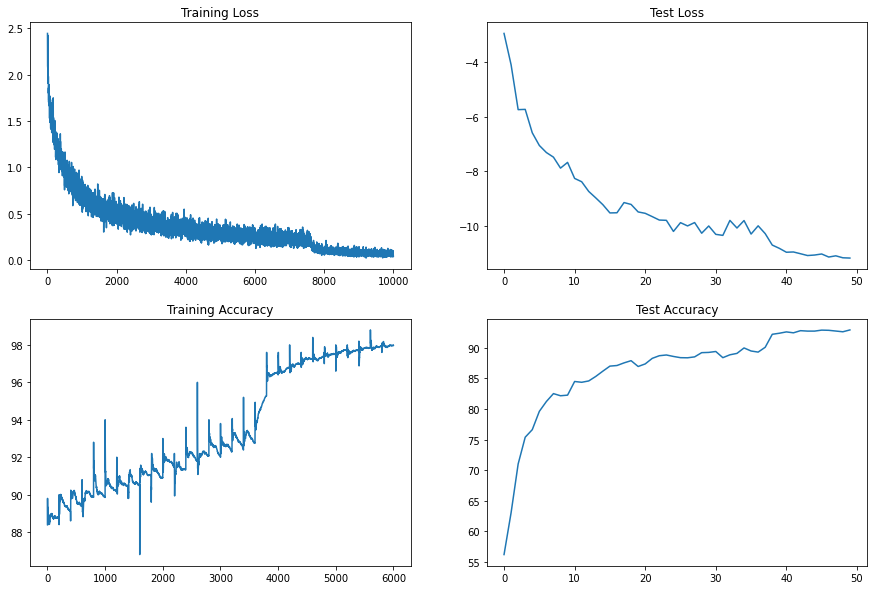

In [9]:
PlotTrainingGraphs(tt)

## MisClassification

In [10]:
wrong = Misclassification(testloader,net,device)

## GradCam

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

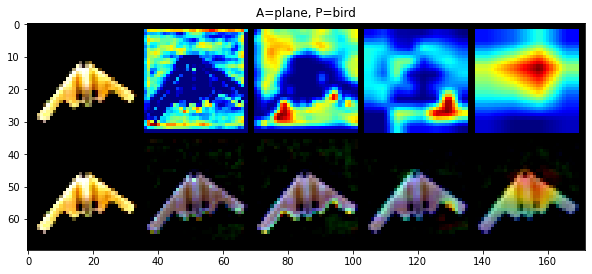

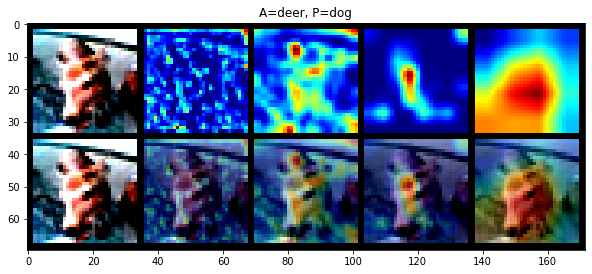

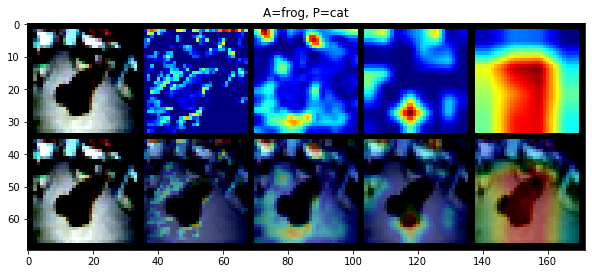

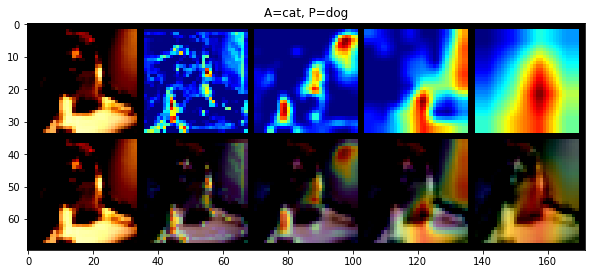

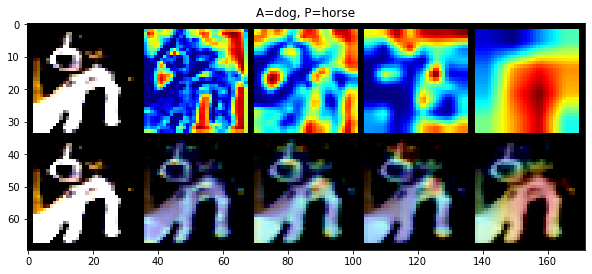

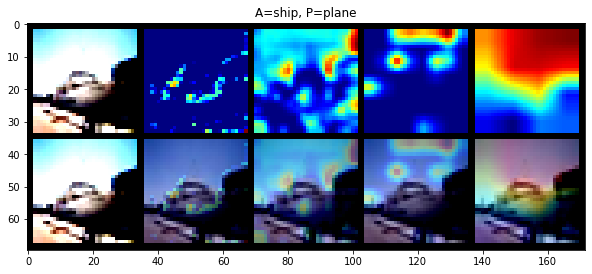

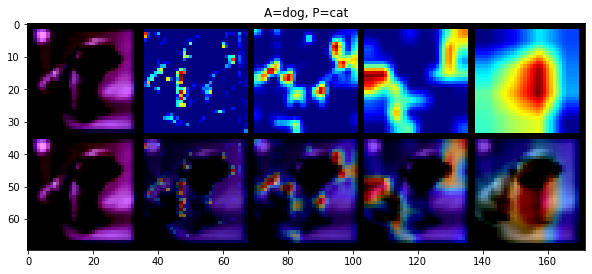

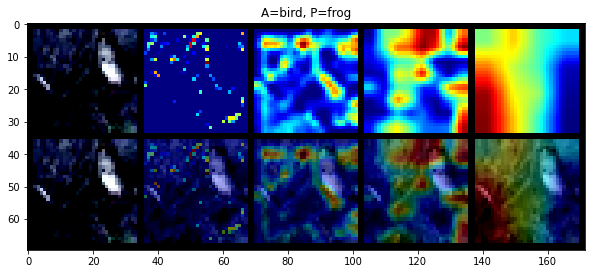

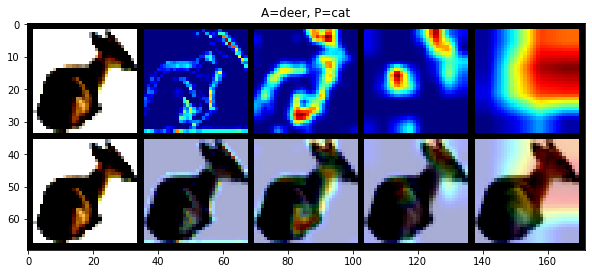

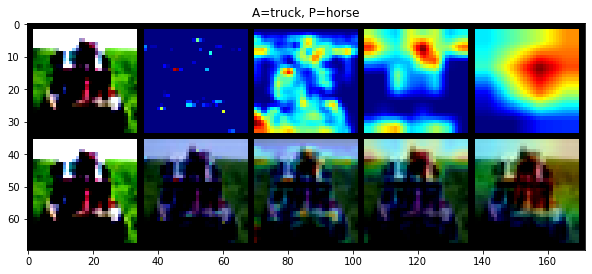

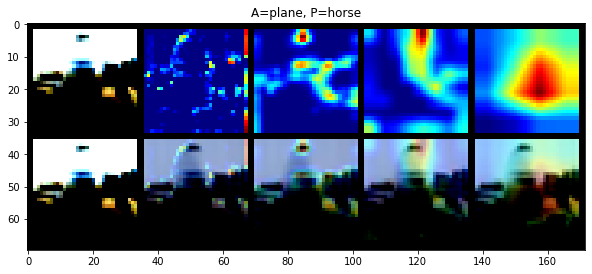

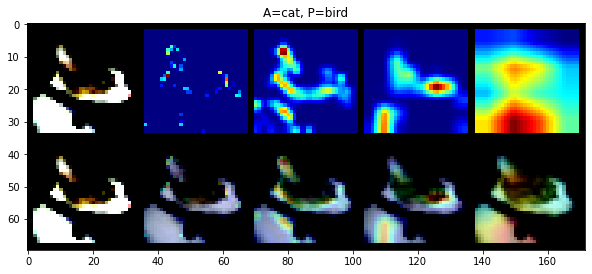

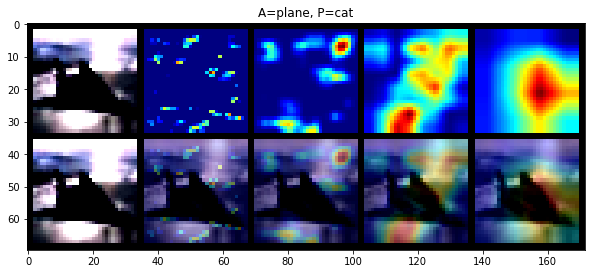

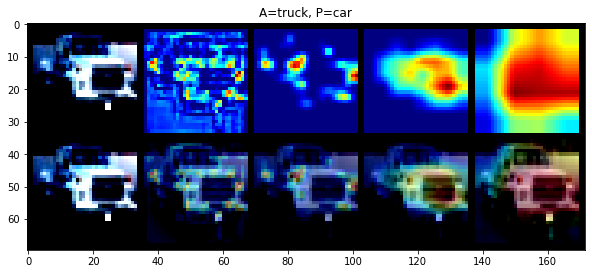

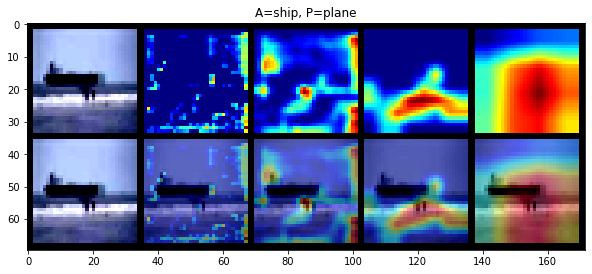

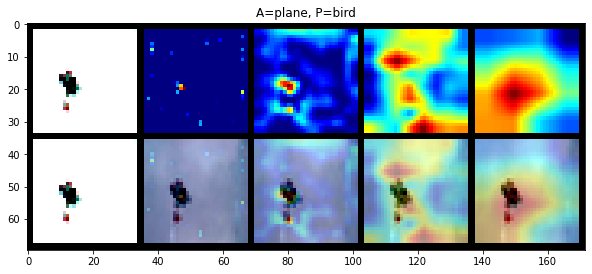

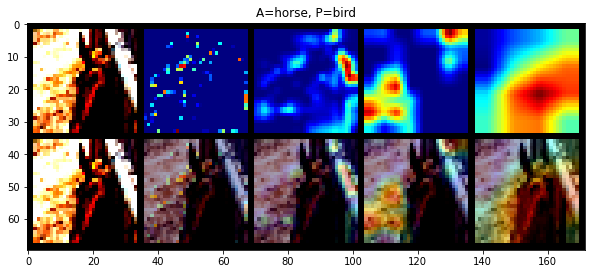

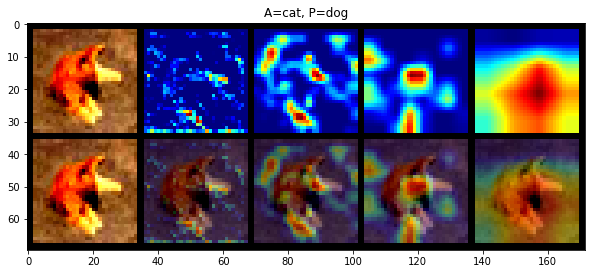

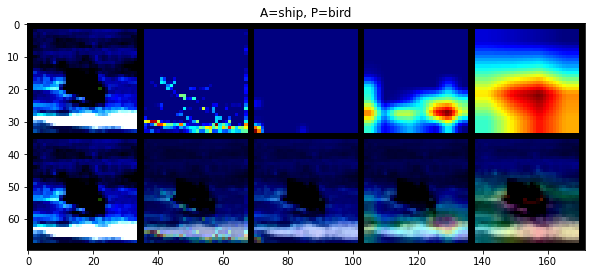

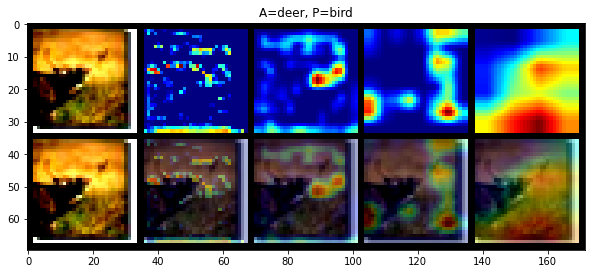

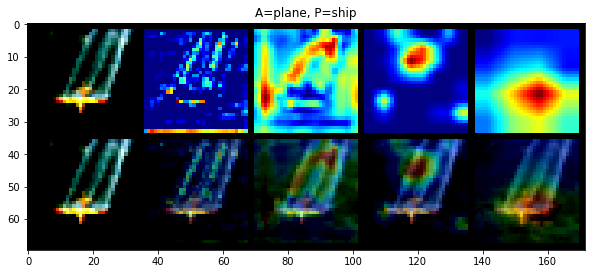

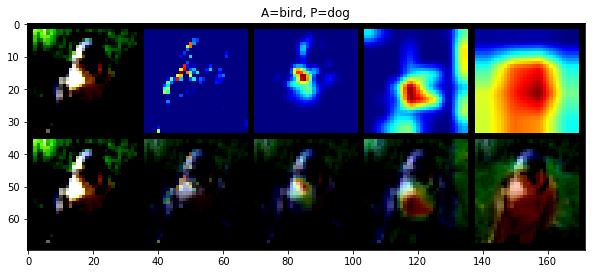

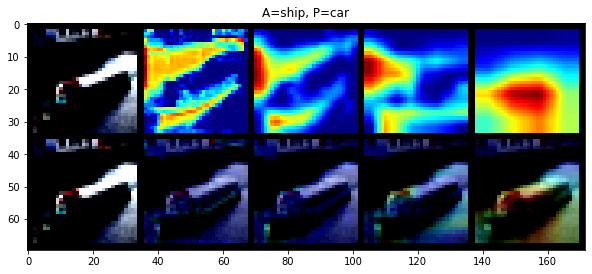

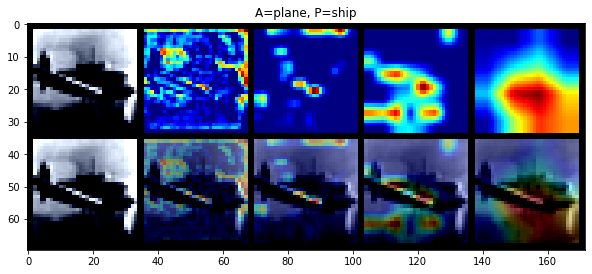

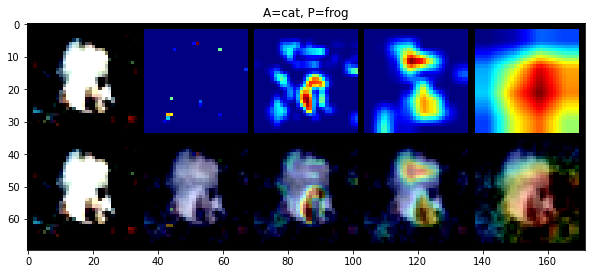

In [11]:
GradCamDisplay(net,wrong,device)